In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['legend.numpoints'] = 1
%matplotlib inline

In [6]:
sns.set(context='notebook',style='ticks')

### 5B

In [351]:
fx = lambda t: -1*np.exp(-1*t)

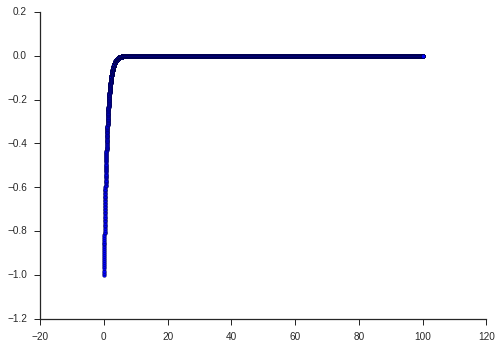

In [352]:
plt.scatter(np.linspace(0,100,10000),[fx(x) for x in np.linspace(0,100,10000)],s=15)
sns.despine()
plt.show()
plt.close()

### 5c

In [355]:
def eulers(init,init_t,timestep,max_t,lambda_fxn):
    n = max_t/timestep+1
    x = np.linspace(init,max_t,n)
    y = np.zeros(int(n))
    y[0] = init_t
    dx = timestep
    for i in xrange(1,int(n)):
        y[i] = dx*(lambda_fxn(x[i]))+y[i-1]
    return(x,y)

In [356]:
dt = 0.01
max_t = 100
init = 0
init_t = -1
x,y = eulers(init,init_t,dt,max_t,fxn)

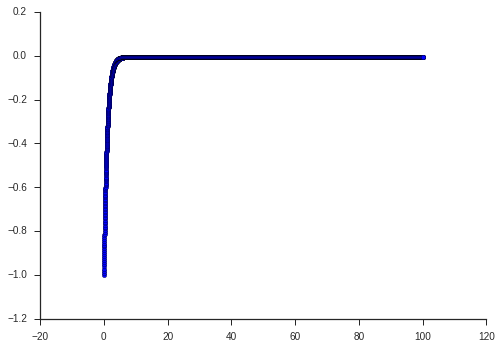

In [357]:
plt.scatter(x,y)
sns.despine()
plt.show()
plt.close()

### 5d

Another timestep and calculating error from analytical solution.

In [424]:
rmse = lambda est,real: sum([(est[i]-real[i])**2 for i in xrange(len(est))])/len(est)

In [425]:
dt_times = [1,0.1,0.01,0.001,0.0001]
rmses = []
max_t = 100
init = 0
init_t = -1
fxn = lambda y: np.exp(-1*y)
fxa = lambda t: -1*np.exp(-1*t)
for dt in dt_times:
    x_smaller,y_smaller = eulers(init,init_t,dt,max_t,fxn)
    rmse_dt = rmse(y_smaller,fxa(x_smaller))
    rmses.append(rmse_dt)

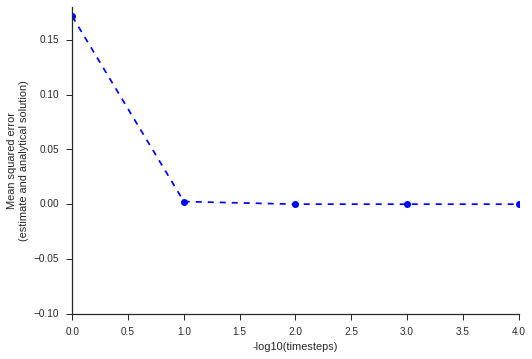

In [441]:
plt.plot(-1*np.log10(dt_times),rmses,'bo--')
plt.xlabel('-log10(timesteps)')
plt.ylim([-0.1,0.18])
plt.ylabel('Mean squared error\n(estimate and analytical solution)')
sns.despine()
plt.show()
plt.close()

Run time for euler's increases for smaller time scales and the error decreases for smaller time scales

### 5e

Euler's method for Hodgkin-Huxley ODE

In [169]:
alpha_m = lambda v: (2.5 - .1*v) / (np.exp(2.5 - .1*v) - 1)
beta_m = lambda v: 4*np.exp(-1*v/18)
alpha_h = lambda v: .07*np.exp(-1*v/20)
beta_h = lambda v: 1 / (np.exp(3-.1*v) + 1)
alpha_n = lambda v: (.1 - .01*v) / (np.exp(1-.1*v)-1)
beta_n = lambda v: .125 * np.exp(-v/80)

def hodge_hux_eulers(init_input,I,dt,max_t):
    v = init_input[0]
    m = init_input[1] 
    h = init_input[2] 
    n = init_input[3]
    gNa = 120
    vNa = 115
    gl = 0.3
    Vl = 10.6 

    gk = 36
    Vk = -12 
    
    n_times = int(max_t/dt)+1
    V = np.zeros(n_times)
    M = np.zeros(n_times)
    H = np.zeros(n_times)
    N = np.zeros(n_times)
    
    #Set the initials
    V[0] = v
    M[0] = m
    H[0] = h
    N[0] = n
    time = np.linspace(0,max_t,n_times)
    #Run euler's 
    for i in xrange(1,int(n_times)):
        V[i] = V[i-1]+dt*(I[i-1] + gNa*(M[i-1]**3)*(H[i-1])*(vNa - V[i-1]) + gl*(Vl - V[i-1]) + gk*(N[i-1]**4)*(Vk -V[i-1]))  
        M[i] = M[i-1]+dt*(alpha_m(V[i-1]) * (1 - M[i-1]) - beta_m(V[i-1]) * M[i-1] ) 
        H[i] = H[i-1] + dt*(alpha_h(V[i-1]) * (1 - H[i-1]) - beta_h(V[i-1]) * H[i-1])
        N[i] = N[i-1]+ dt*(alpha_n(V[i-1]) * (1 - N[i-1]) - beta_n(V[i-1]) * N[i-1])
    return np.matrix([time,V,M,H,N]).T

In [396]:
maxtime = 100
dt = 0.01
I = np.zeros(maxtime/dt+1)
I[int(50/dt):int(80/dt)]=20
tt = hodge_hux_eulers([0,0,0,0],I,dt,max_t)

/cellar/users/twang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


In [397]:
ttdf = pd.DataFrame(tt,columns=['time','Voltage','m','h','n'])

Plotting results for 5e versus time

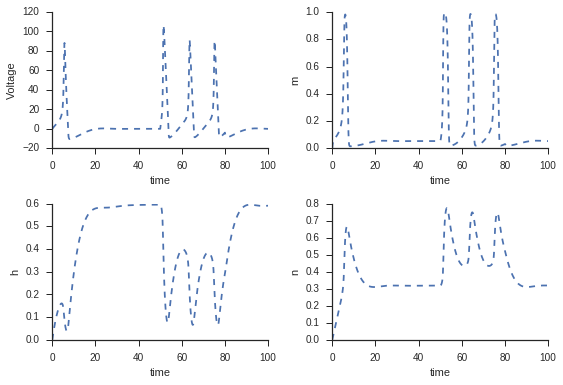

In [398]:
ttdf = pd.DataFrame(tt,columns=['time','Voltage','m','h','n'])
colnames = ['Voltage','m','h','n']
i=0
j=0
f,axes = plt.subplots(2,2)
for col in colnames:
    if j == 2:
        j=0
        i=1
    ax = axes[i][j]
    ax.plot(ttdf['time'],ttdf[col],'--')
    ax.set_xlabel('time')
    ax.set_ylabel(col)
    j=j+1
f.tight_layout()
sns.despine()
plt.show()
plt.close()

Varying input stimuli and calculating spikes per second

In [510]:
def get_spikes_per_second(dataframe_in,window_voltage_examined):
    dataframe_in = dataframe_in.sort_values(by='time')
    voltage_thresh = np.mean([dataframe_in['Voltage'].max(),dataframe_in['Voltage'].min()])
    voltages = dataframe_in.loc[(dataframe_in.time>=window_voltage_examined[0]) & (dataframe_in.time<=window_voltage_examined[1]),'Voltage'].values
    times = dataframe_in.loc[(dataframe_in.time>=window_voltage_examined[0]) & (dataframe_in.time<=window_voltage_examined[1]),'time'].values
    shape_trend = 1
    count_spikes = 0
    last_v = voltages[0]
    last_time = times[0]
    save_iters = []
    for i in range(1,len(voltages[1:])+1):
        this_time = times[i]
        this_voltage = voltages[i]
        dvdt = (this_voltage-last_v)/(this_time-last_time)
        if dvdt > 0:
            shape_trend_dt = 1
        if dvdt < 0:
            shape_trend_dt = -1
        if shape_trend_dt != shape_trend:
            if this_voltage > voltage_thresh and shape_trend_dt == -1:
                count_spikes = count_spikes+1
                shape_trend = shape_trend_dt
            else:
                shape_trend = shape_trend_dt
        last_v = this_voltage
        last_time = this_time    
    return(count_spikes/(window_voltage_examined[1]-window_voltage_examined[0]))

In [515]:
varying_stimuli_amt = [0,20,40,60,80,100]
spikes_per_second_var = []
maxtime = 100
dt = 0.01
window_ex = [50,80]
for amt in varying_stimuli_amt:
    I = np.zeros(int(maxtime/dt+1))
    I[int(window_ex[0]/dt):int(window_ex[1]/dt)]=amt
    tt_iter = hodge_hux_eulers([0,0,0,0],I,dt,maxtime)
    tt_iterdf = pd.DataFrame(tt_iter,columns=['time','Voltage','m','h','n'])
    spikes_per_sec_iter = get_spikes_per_second(tt_iterdf,window_ex)
    spikes_per_second_var.append(spikes_per_sec_iter)

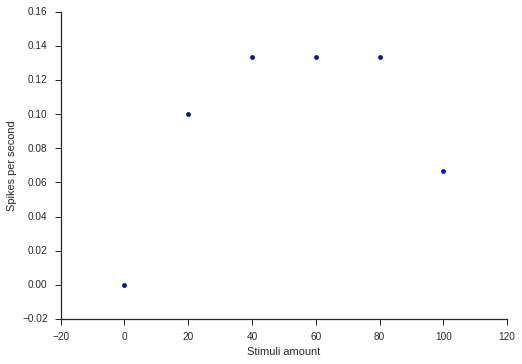

In [517]:
plt.scatter(varying_stimuli_amt,spikes_per_second_var,s=20)
plt.xlabel('Stimuli amount')
plt.ylabel('Spikes per second')
sns.despine()